# 03_Classification

In [290]:
from sklearn.datasets import fetch_mldata
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import warnings

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import time

In [137]:
warnings.filterwarnings('ignore')

In [138]:
mnist=fetch_mldata('MNIST original')

In [139]:
# check the structure of mnist
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [140]:
X,y=mnist.data,mnist.target

In [141]:
# get and visualize one digit from the datase
some_digit=X[36000] # get the 36000th digit in the dataset
some_digit.shape

(784,)

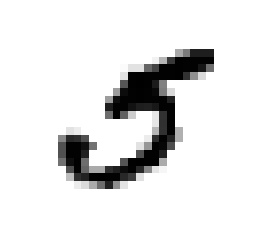

In [142]:
def imshowImageofInstance(index):
    someInstance=X[index]
    someImage=someInstance.reshape(28,28)
    plt.imshow(someImage,cmap=matplotlib.cm.binary,interpolation='nearest')
    plt.axis('off')
    plt.show()    
    
%matplotlib inline
imshowImageofInstance(36000)

In [143]:
# split the dataset into the training dataset and testing dataset
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

In [144]:
#shuffle the training dataset so that when we use cross validation we can get the similar dataset
shuffled_Index=np.random.permutation(60000)
X_train,y_train=X[shuffled_Index],y[shuffled_Index]

# Training a binary classifier to classify 5s and Non-5s

In [145]:
# construct the a target vector
y_train_5=(y_train==5)
y_test_5=(y_test==5)

In [146]:
sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [147]:
sgd_clf.predict([some_digit])

array([ True])

In [148]:
sgd_clf.classes_

array([False,  True])

# Evaluate the performance of the classifier based on the cross-validation

In [149]:
# implement the cross validation by own
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

kfolds=StratifiedKFold(n_splits=3,random_state=42)
for train_index,test_index in kfolds.split(X_train,y_train_5):
    sgd_clf_clone=clone(sgd_clf)
    X_train_folds=X_train[train_index]
    y_train_folds=y_train_5[train_index]
    
    X_test_folds=X_train[test_index]
    y_test_folds=y_train_5[test_index]
    
    sgd_clf_clone.fit(X_train_folds,y_train_folds)
    y_pred=sgd_clf_clone.predict(X_test_folds)
    n_correct=sum(y_pred==y_test_folds)
    accuracy=n_correct /len(y_pred)*100
    print('Accuracy in this fold: {:.2f}%'.format(accuracy))

Accuracy in this fold: 96.41%
Accuracy in this fold: 92.83%
Accuracy in this fold: 93.49%


In [150]:
# Using the built-in Cross-validation -- cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.96415, 0.9283 , 0.9349 ])

# Build a dumb classifier that can classify all the samples to the non-5s class

In [151]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [152]:
never5Clf=Never5Classifier()
never5Clf.fit(X_train,y_train_5)
y_pred_never5=never5Clf.predict(X_train)

In [153]:
n_correct=sum(y_pred_never5.ravel()==y_train_5)
accuracy=n_correct/len(y_train_5)
print('Accuracy: ',accuracy)

Accuracy:  0.90965


In [154]:
cross_val_score(never5Clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.9092 , 0.9109 , 0.90885])

In [155]:
cross_val_score(never5Clf,X_train,y_train_5,cv=3,scoring='precision')

array([0., 0., 0.])

In [156]:
cross_val_score(never5Clf,X_train,y_train_5,cv=3,scoring='recall')

array([0., 0., 0.])

In [157]:
cross_val_score?

# Confusion Matrix

To build the confusion matrix,we have to have a set of prediction values, so they can be used to compare with the actual values.
To get the predicted values, we can use the function of cross_val_predict()

In [158]:
from sklearn.model_selection import cross_val_predict
y_train_pred=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [159]:
y_train_pred

array([False, False, False, ...,  True, False,  True])

In [160]:
#build the confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_train_5,y_train_pred)

In [161]:
confusion_matrix(y_train_5,y_train_pred)

array([[51965,  2614],
       [  839,  4582]], dtype=int64)

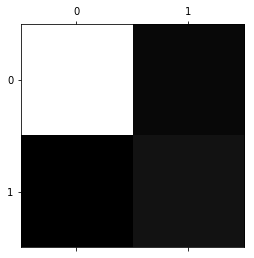

In [162]:
# show the confusion_matrix
plt.matshow(cm,cmap=plt.cm.gray)
plt.show()

In [163]:
y_train_perfect_predictions=y_train_5.copy()

In [164]:
pcm=confusion_matrix(y_train_5,y_train_perfect_predictions)

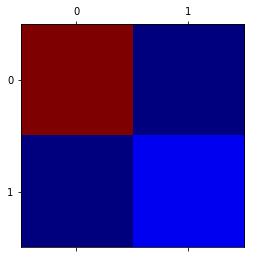

In [165]:
plt.matshow(pcm,cmap=plt.get_cmap('jet'))
plt.show()

# Precision Recall F1-Measure

In [166]:
# precision is the ratio of predicted true positive samples out of predicted positive samples=(TP/(TP+FP))
# recall is the ratio of predicted true postive samples out of the true samples in the dataset=(TP/(TP+FN))
# F1-measure is harmonic mean of precision and recall which gives more weights to low values
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
precision=precision_score(y_train_5,y_train_pred)
recall=recall_score(y_train_5,y_train_pred)
f1=f1_score(y_train_5,y_train_pred)

In [167]:
precision

0.6367426347971095

In [168]:
52427/(52427+1377)

0.9744071072782693

In [169]:
recall

0.8452315071020107

In [170]:
f1

0.726321629547436

# Precision/Recall Tradeoff

In [171]:
y_scores=sgd_clf.decision_function([some_digit])
threshold=0
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([ True])

In [172]:
y_scores_all=sgd_clf.decision_function(X_train)

In [173]:
y_scores=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')

In [174]:
y_scores

array([ -349610.22001082, -1194206.46178314,  -790421.36832497, ...,
         160108.85411451,  -371008.16636817,   225244.20304659])

In [175]:
y_scores_all

array([-125111.12535882, -600583.00400291, -516104.35124992, ...,
          -853.9019129 , -514625.74168644,  -19209.67718126])

In [176]:
# for these scores, compute the precision and recall for all possible threshold using the precision_recall_curve()
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds=precision_recall_curve(y_train_5,y_scores)

In [177]:
thresholds

array([-1913866.50984306, -1913781.86175963, -1912920.40421116, ...,
        1032704.25063781,  1046786.85801396,  1068830.63879998])

In [178]:
y_scores

array([ -349610.22001082, -1194206.46178314,  -790421.36832497, ...,
         160108.85411451,  -371008.16636817,   225244.20304659])

In [179]:
precisions

array([0.09047365, 0.09045847, 0.09045998, ..., 1.        , 1.        ,
       1.        ])

In [180]:
recalls

array([1.00000000e+00, 9.99815532e-01, 9.99815532e-01, ...,
       3.68935621e-04, 1.84467810e-04, 0.00000000e+00])

In [181]:
# check the precision when the threshold is set as -1867474.4104284
threshold=-1867474.4104284
y_train_preds=(y_scores>threshold)
precision_score(y_train_5,y_train_preds)

0.09049320466156877

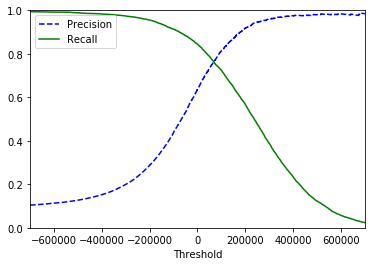

In [182]:
# plot the precision against threshold and recall against threshold
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    # the last values in precisions and recalls are 1. and 0.,respectively, they do not have corresponding
    # threshold, it just ensures the graphs begin at the y-axis
    plt.plot(thresholds,precisions[:-1],'b--',label='Precision')
    plt.plot(thresholds,recalls[:-1],'g-',label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.xlim([-700000,700000])
    plt.ylim([0,1])
    plt.show()
%matplotlib inline    
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)

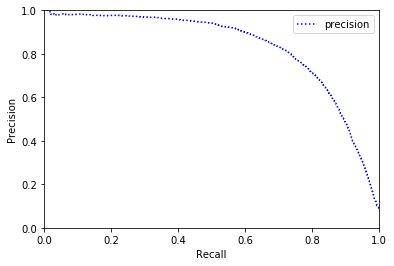

In [183]:
# plot the curve precision vs recall
plt.plot(recalls[:-1],precisions[:-1],'b:',label='precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc='upper right')
plt.show()

In [184]:
y_train_90_precision=(y_scores>=300000)

In [185]:
precision_score(y_train_5,y_train_90_precision)

0.9598723210214318

In [186]:
recall_score(y_train_5,y_train_90_precision)

0.3883047408227264

# ROC curve

In [187]:
# To plot the roc curve, you need to get the TPR and FRP
from sklearn.metrics import roc_curve
fpr_sgd,tpr_sgd,thresholds_sgd=roc_curve(y_train_5,y_scores)

In [188]:
thresholds

array([-1913866.50984306, -1913781.86175963, -1912920.40421116, ...,
        1032704.25063781,  1046786.85801396,  1068830.63879998])

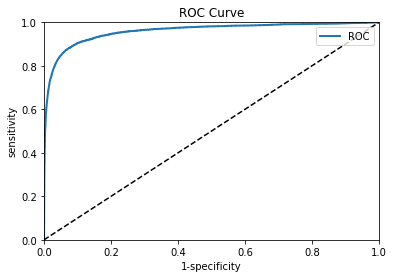

In [189]:
# plot roc curve (tpr vs fpr)
%matplotlib inline
def plot_roc_curve(fpr,tpr,color=None,label=None):
    plt.plot(fpr,tpr,linewidth=2,color=color,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('1-specificity')
    plt.ylabel('sensitivity')
    plt.legend(loc='upper right')
    plt.title('ROC Curve')
   

plot_roc_curve(fpr_sgd,tpr_sgd,label='ROC')
plt.show()

In [190]:
# how to calculate the ROC AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9592277131535453

# The performance comparison of two classifiers based on the roc curve and roc auc

In [191]:
# build a random forest classifier
rdf_clf=RandomForestClassifier(random_state=42)
rdf_clf.fit(X_train,y_train_5)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [192]:
y_probas_forest=cross_val_predict(rdf_clf,X_train,y_train_5,cv=3,method='predict_proba') #there are two values in each row, which
# means the probability of the instance belongs to each of the class respectively.
y_probas_forest

array([[0.9, 0.1],
       [1. , 0. ],
       [0.8, 0.2],
       ...,
       [0.8, 0.2],
       [1. , 0. ],
       [0.5, 0.5]])

In [193]:
# use the probability belongs to positive class as pred_scores
y_scores_forest=y_probas_forest[:,1]
y_scores_forest

array([0.1, 0. , 0.2, ..., 0.2, 0. , 0.5])

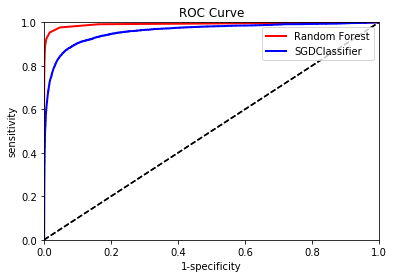

In [194]:
# using roc_curve() to plot the fpr tpr 
fpr_forest,tpr_forest,thresholds=roc_curve(y_train_5,y_scores_forest)
plot_roc_curve(fpr_forest,tpr_forest,'r','Random Forest')
plot_roc_curve(fpr_sgd,tpr_sgd,'b','SGDClassifier')
plt.show()

In [195]:
# using precision_recall_curve() calc precision,recall,threshold
precisions,recalls,thresholds=precision_recall_curve(y_train_5,y_scores_forest)

In [196]:
# calc the roc auc
sgd_auc=roc_auc_score(y_train_5,y_scores)
rdf_auc=roc_auc_score(y_train_5,y_scores_forest)

In [197]:
roc_auc_score(y_train_5,y_train_pred)

0.8986688142520076

In [198]:
sgd_auc

0.9592277131535453

In [199]:
rdf_auc

0.9919070464341058

In [200]:
# using the random forest for prediction
y_pred_forest=cross_val_predict(rdf_clf,X_train,y_train_5,cv=3)

In [201]:
y_pred_forest

array([False, False, False, ..., False, False, False])

In [202]:
precision_score(y_train_5,y_pred_forest)

0.9838709677419355

In [203]:
recall_score(y_train_5,y_pred_forest)

0.8326876959970485

# MultiClass Classification

In [204]:
# trying to use Stochastical Gradient Descent Classifier to do the MultiClass Classification task
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([5.])

In [205]:
some_digit_scores=sgd_clf.decision_function([some_digit])

In [206]:
np.argmax(some_digit_scores)

5

In [207]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [208]:
sgd_clf.classes_[5]

5.0

In [209]:
# to train the classifier based on onevsoneclassifier
from sklearn.multiclass import OneVsOneClassifier
ovo_clf=OneVsOneClassifier(SGDClassifier(random_state=42))

ovo_clf.fit(X_train,y_train)
ovo_clf.predict([some_digit])
%time

Wall time: 0 ns


In [210]:
len(ovo_clf.estimators_)

45

In [211]:
# to train a classifier based on the onevsallClassifier
from sklearn.multiclass import OneVsRestClassifier
ova_clf=OneVsRestClassifier(SGDClassifier(random_state=42))

ova_clf.fit(X_train,y_train)
ova_clf.predict([some_digit])
%time

Wall time: 0 ns


In [212]:
ova_clf.decision_function([some_digit])

array([[-238251.3265831 , -416388.82673108, -385386.42062309,
        -254834.38374838, -503264.34849021,   10390.58727144,
        -806936.52038621, -217584.68971116, -614411.01621596,
        -628373.13664679]])

In [213]:
len(ova_clf.estimators_)

10

In [214]:
# train a Random Forest Classifier 
forest_clf=RandomForestClassifier(random_state=42)
forest_clf.fit(X_train,y_train)
forest_clf.predict([some_digit])

array([5.])

In [215]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.1, 0. , 0.9, 0. , 0. , 0. , 0. ]])

In [216]:
cross_val_score(forest_clf,X_train,y_train,cv=3,scoring='accuracy')

array([0.94261148, 0.94139707, 0.93819073])

In [217]:
#standardscalar dataset
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

array([0.91021796, 0.91024551, 0.90903636])

# Error Analysis

In [218]:
y_sgd_pred=cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)

In [219]:
# confusion matrix
conf_mx=confusion_matrix(y_train,y_sgd_pred)
conf_mx

array([[5734,    2,   25,   11,   13,   42,   45,    8,   39,    4],
       [   1, 6476,   45,   25,    6,   44,    6,   10,  118,   11],
       [  56,   37, 5319,  104,   88,   26,   87,   58,  169,   14],
       [  48,   39,  131, 5344,    3,  233,   32,   57,  145,   99],
       [  18,   26,   44,    6, 5385,    7,   54,   25,   69,  208],
       [  70,   41,   40,  200,   77, 4570,  100,   25,  193,  105],
       [  41,   24,   42,    1,   40,   93, 5623,    5,   48,    1],
       [  23,   19,   67,   29,   51,   11,    5, 5816,   15,  229],
       [  49,  145,   70,  140,   15,  151,   56,   28, 5064,  133],
       [  49,   37,   33,   85,  169,   32,    2,  205,   78, 5259]],
      dtype=int64)

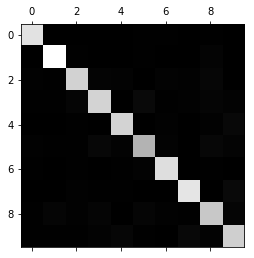

In [220]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

In [221]:
conf_mx

array([[5734,    2,   25,   11,   13,   42,   45,    8,   39,    4],
       [   1, 6476,   45,   25,    6,   44,    6,   10,  118,   11],
       [  56,   37, 5319,  104,   88,   26,   87,   58,  169,   14],
       [  48,   39,  131, 5344,    3,  233,   32,   57,  145,   99],
       [  18,   26,   44,    6, 5385,    7,   54,   25,   69,  208],
       [  70,   41,   40,  200,   77, 4570,  100,   25,  193,  105],
       [  41,   24,   42,    1,   40,   93, 5623,    5,   48,    1],
       [  23,   19,   67,   29,   51,   11,    5, 5816,   15,  229],
       [  49,  145,   70,  140,   15,  151,   56,   28, 5064,  133],
       [  49,   37,   33,   85,  169,   32,    2,  205,   78, 5259]],
      dtype=int64)

In [222]:
# normalized confusion matrix
row_sum=conf_mx.sum(axis=1,keepdims=True)
row_sum

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]], dtype=int64)

In [223]:
len(row_sum)

10

In [224]:
norm_conf_mx=conf_mx/row_sum

In [225]:
np.fill_diagonal(norm_conf_mx,0)

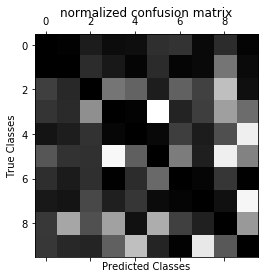

In [226]:
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.title('normalized confusion matrix')
plt.tight_layout()
plt.show()

In [259]:
def plot_digits(data,images_per_row):
    l=len(data)
    row=np.round(l/images_per_row)
    images=[]
    for j in range(l):
        images.append(data[j].reshape(28,28))
    for i in range(l):
        plt.subplot(row,images_per_row,i+1)
        plt.axis('off')
        plt.imshow(images[i],cmap=plt.cm.binary)
        

In [260]:
# plot the 3 vs 5 classification results
cl_a,cl_b=3,5
x_aa=X_train[(y_train==cl_a)&(y_sgd_pred==cl_a)] # select the features of y_train =3 and those were predicted as 3
x_ab=X_train[(y_train==cl_a)&(y_sgd_pred==cl_b)] # 3->5
x_bb=X_train[(y_train==cl_b)&(y_sgd_pred==cl_b)] # 5->5
x_ba=X_train[(y_train==cl_b)&(y_sgd_pred==cl_a)] # 5->3

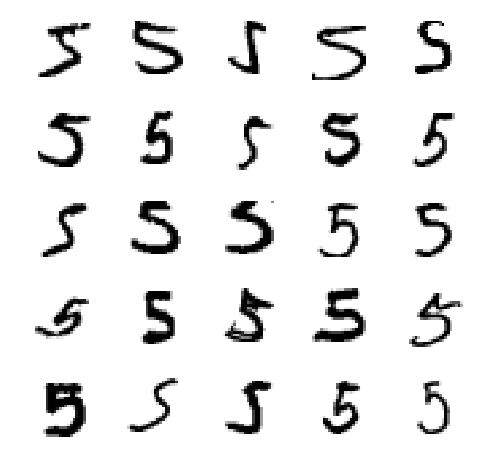

In [281]:
plt.figure(figsize=(8,8))

plt.subplot(221);plot_digits(x_aa[:25],images_per_row=5)

plt.subplot(222);plot_digits(x_ab[:25],images_per_row=5)

plt.subplot(223);plot_digits(x_bb[:25],images_per_row=5)
plt.subplot(224);plot_digits(x_ba[:25],images_per_row=5)
plt.show()

# MultiLabel Classification

In [289]:
y_larger_nums=(y_train>=7)
y_odd_nums=(y_train%2==1)
y_multi_labels=np.c_[y_larger_nums,y_odd_nums]

In [292]:
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_multi_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [293]:
knn_clf.predict([some_digit])

array([[False,  True]])

# Evaluating the MultiLabel Classifiers

In [ ]:
y_train_knn_pred=cross_val_predict(knn_clf,X_train,y_multi_labels,cv=3)

In [ ]:
y_train_knn_pred